<a href="https://colab.research.google.com/github/SLCFLAB/DL-Forecasting/blob/main/%EA%B8%88%EC%9C%B5%EC%97%B0%EC%88%98%EC%9B%90/TimeSeriesPractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
import itertools
import scipy.stats
import seaborn as sns
import warnings
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots  import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings(action='ignore')

# Data

### Data Load

In [3]:
gold_url = 'https://raw.githubusercontent.com/SLCFLAB/DL-Forecasting/main/DL/day1/data/gold.csv'
silver_url = 'https://raw.githubusercontent.com/SLCFLAB/DL-Forecasting/main/DL/day1/data/silver.csv'
platinum_url = 'https://raw.githubusercontent.com/SLCFLAB/DL-Forecasting/main/DL/day1/data/platinum.csv'
gold = pd.read_csv(gold_url, index_col=0)
silver = pd.read_csv(silver_url, index_col=0)
platinum = pd.read_csv(platinum_url, index_col=0)

In [4]:
price = gold.set_index(keys = 'Date')
diff = price.diff().dropna()

### Data describe

In [5]:
gold

,Date,Price
0,2017-01-03,1162.0
1,2017-01-04,1165.3
2,2017-01-05,1181.3
3,2017-01-06,1173.4
4,2017-01-09,1184.9
...,...,...
1285,2021-12-27,1808.8
1286,2021-12-28,1810.9
1287,2021-12-29,1805.8
1288,2021-12-30,1814.1


In [6]:
price

,Price
Date,
2017-01-03,1162.0
2017-01-04,1165.3
2017-01-05,1181.3
2017-01-06,1173.4
2017-01-09,1184.9
...,...
2021-12-27,1808.8
2021-12-28,1810.9
2021-12-29,1805.8


In [7]:
gold.isna().sum()

Date     0
Price    0
dtype: int64

In [8]:
gold.describe()

,Price
count,1290.000000
mean,1501.741550
std,254.202298
min,1162.000000
25%,1278.525000
50%,1411.600000
75%,1774.575000
max,2069.400000


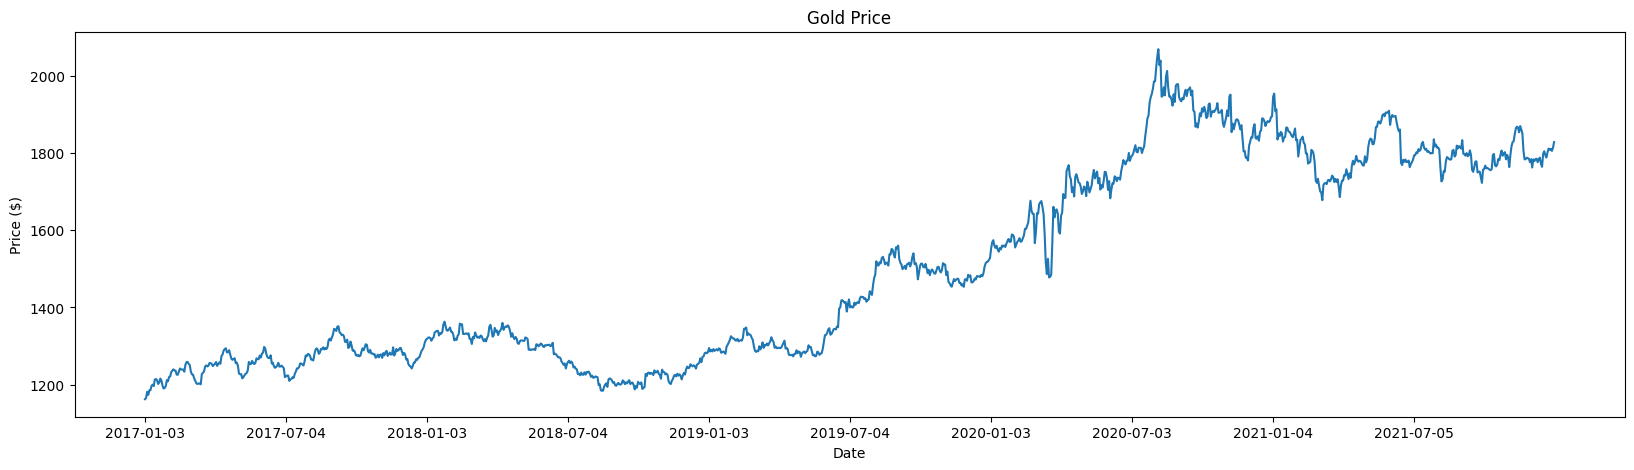

In [9]:
fig, ax = plt.subplots(figsize = (20,5))

ax.plot(price)
ax.set_title('Gold Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')

total_len = gold.shape[0]
ax.set_xticks(np.arange(0,total_len, 129))


plt.show()

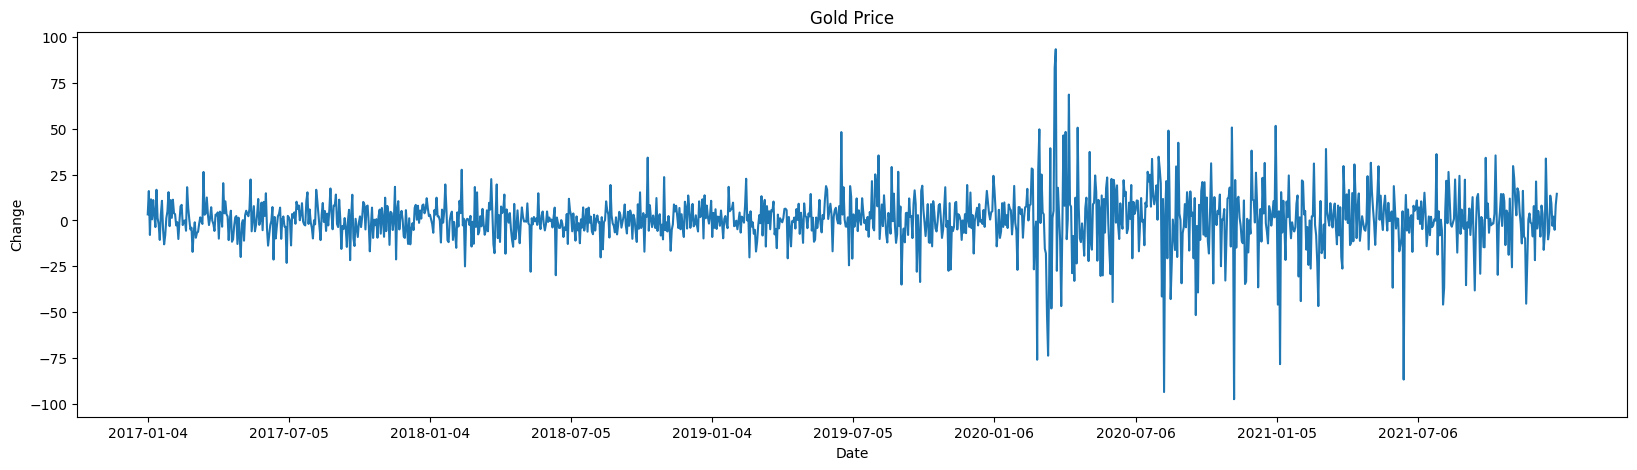

In [10]:
fig, ax = plt.subplots(figsize = (20,5))

ax.plot(diff)
ax.set_title('Gold Price')
ax.set_xlabel('Date')
ax.set_ylabel('Change')

total_len = gold.shape[0]
ax.set_xticks(np.arange(0,total_len, 129))


plt.show()

# Decomposition

### Box-Cox transformation

In [11]:
x = gold['Price'].to_numpy()
y, lambda_optimal = stats.boxcox(x)
print(lambda_optimal)

-1.6225793223320675


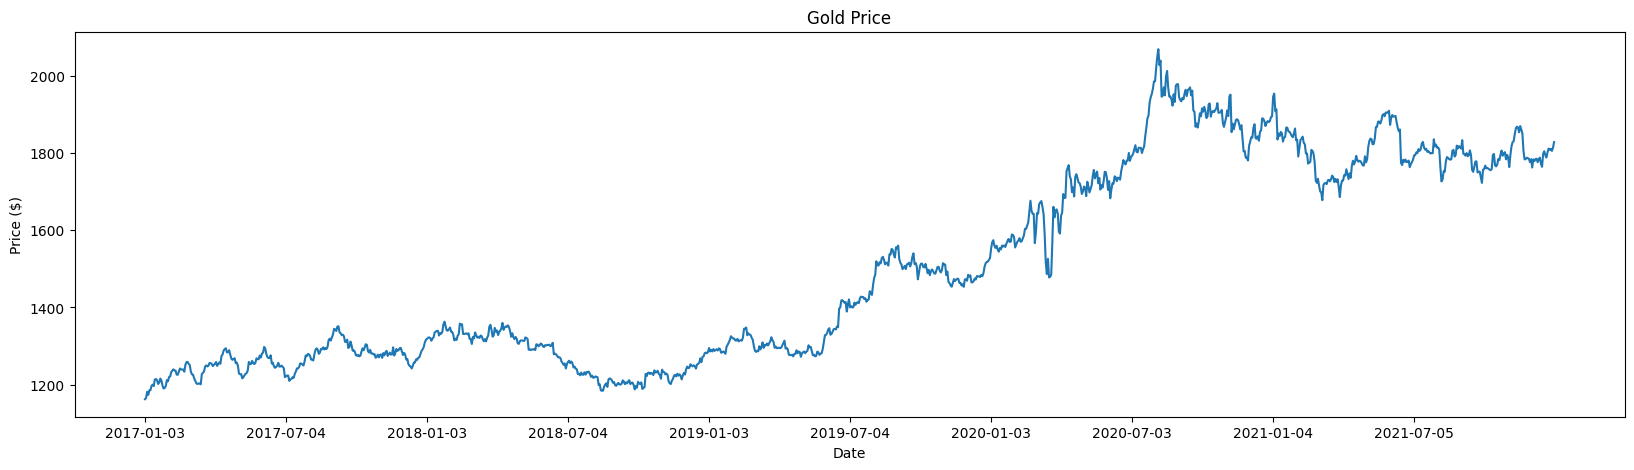

In [12]:
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(price)
ax.set_title('Gold Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
total_len = gold.shape[0]
ax.set_xticks(np.arange(0,total_len, 129))
plt.show()

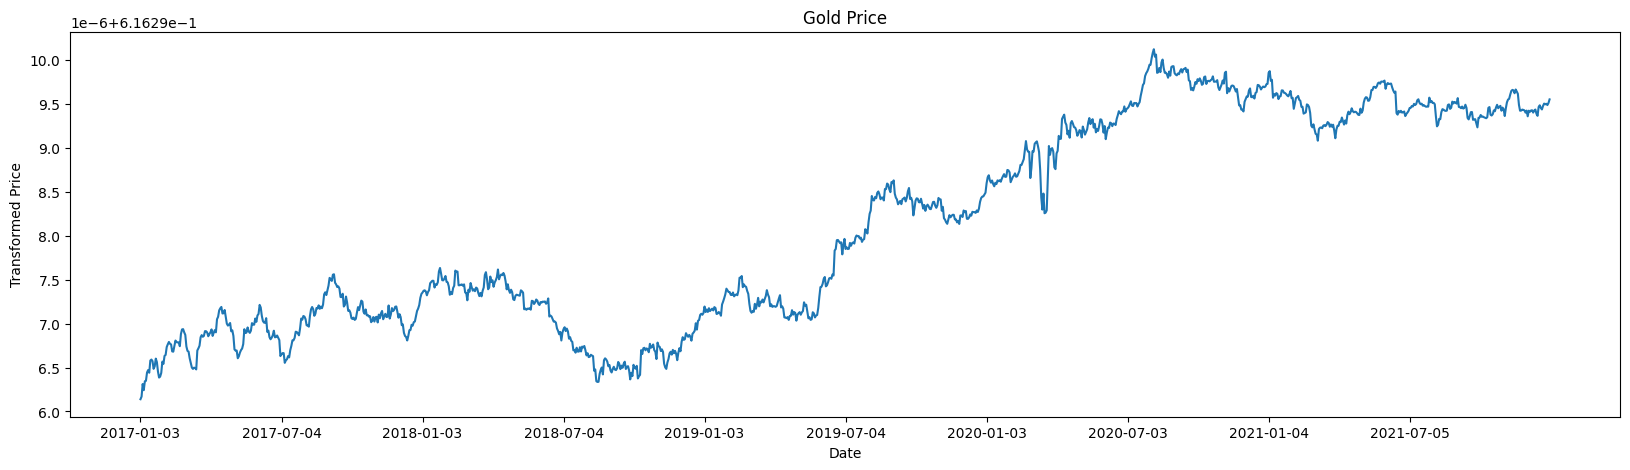

In [13]:
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(gold['Date'],y)
ax.set_title('Gold Price')
ax.set_xlabel('Date')
ax.set_ylabel('Transformed Price')
total_len = gold.shape[0]
ax.set_xticks(np.arange(0,total_len, 129))
plt.show()

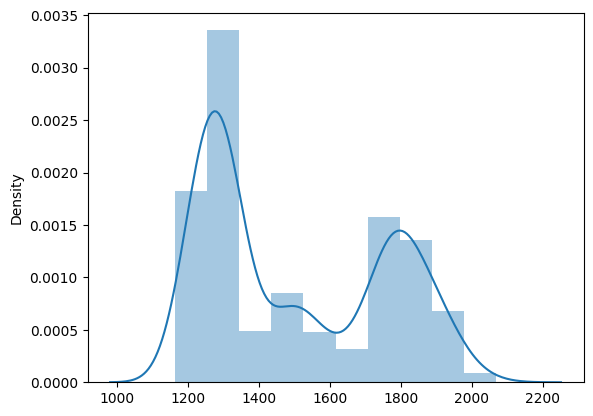

In [14]:
sns.distplot(x, hist=True)
plt.show()

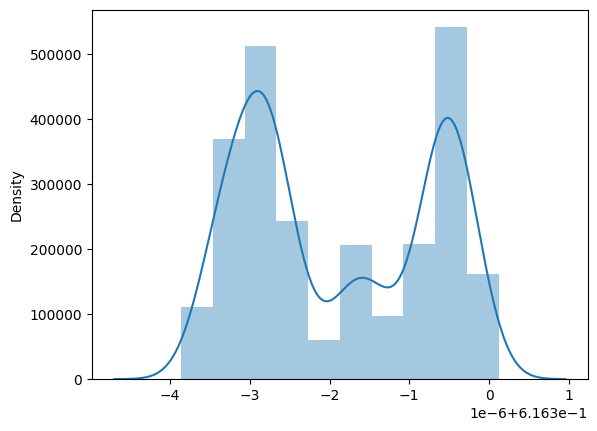

In [15]:
sns.distplot(y, hist=True)
plt.show()

### Moving average

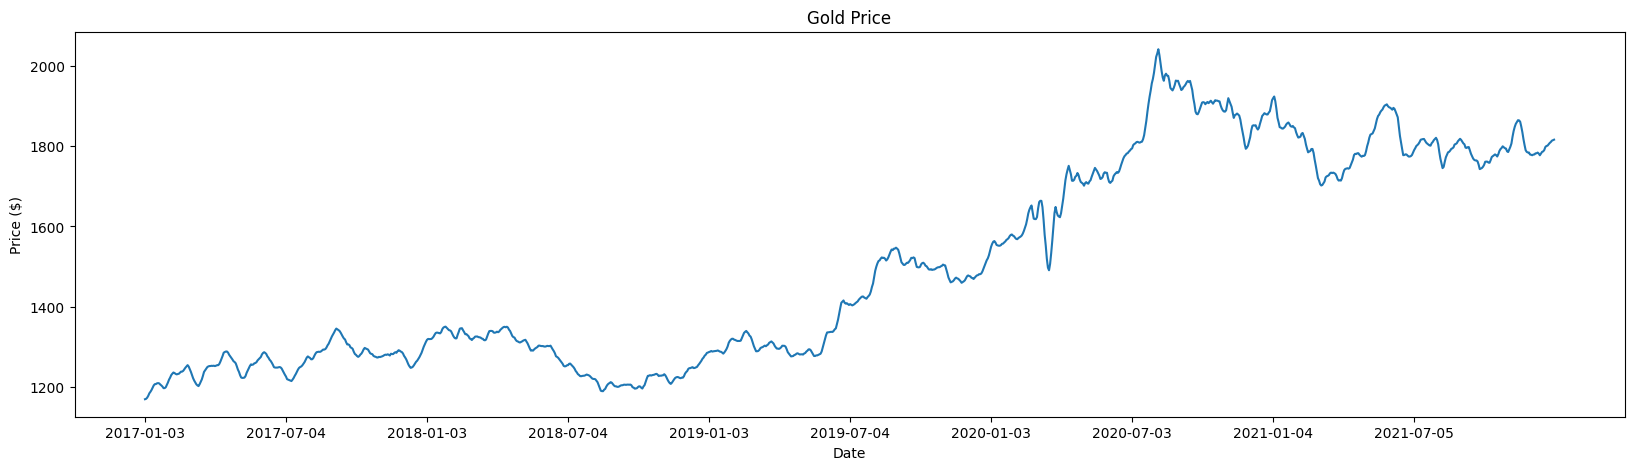

In [16]:
mas = []

for i in range(gold.shape[0]):
    if i >1:
        ma = np.array(gold['Price'][i-2:i+3]).mean()
        mas.append(ma)
    else:
        ma = np.array(gold['Price'][0:i+3]).mean()
        mas.append(ma)

fig, ax = plt.subplots(figsize = (20,5))

ax.plot(gold['Date'], mas)
ax.set_title('Gold Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')

total_len = gold.shape[0]
ax.set_xticks(np.arange(0,total_len, 129))


plt.show()

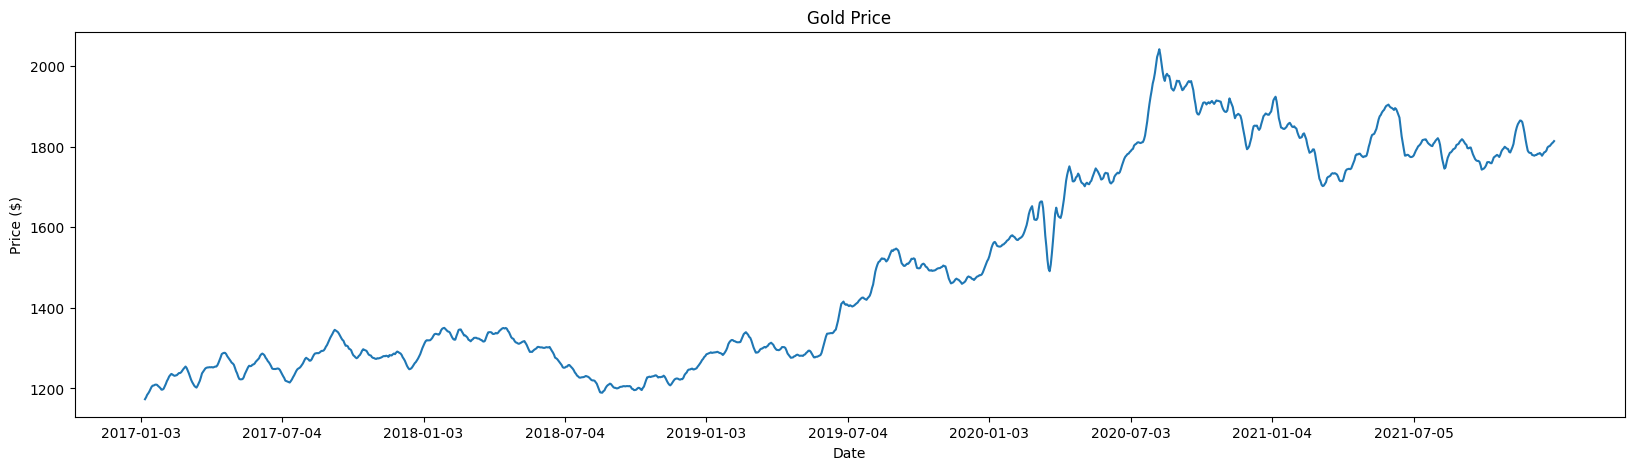

In [17]:
mas = gold['Price'].rolling(5).mean()

fig, ax = plt.subplots(figsize = (20,5))

ax.plot(gold['Date'], mas)
ax.set_title('Gold Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')

total_len = gold.shape[0]
ax.set_xticks(np.arange(0,total_len, 129))


plt.show()

## Classical Decomposition

### Trend -> Moving average
### Seasonal -> 각 period의 data - trend 평균

<Figure size 3000x1000 with 0 Axes>

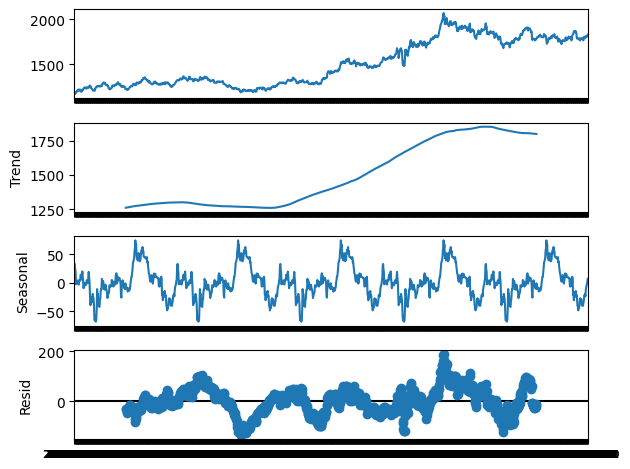

In [18]:
plt.figure(figsize=(30,10))
plt.rc('xtick', labelsize= 8)
gold_decomp = seasonal_decompose(price, model = 'additive',  period = 258)
gold_decomp.plot()
plt.show()

<Figure size 3000x1000 with 0 Axes>

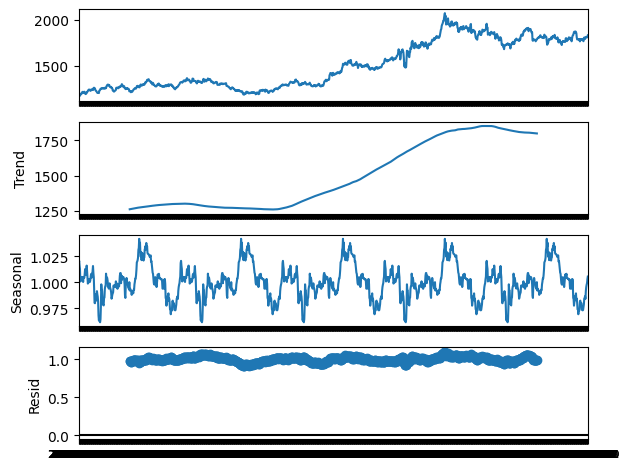

In [19]:
plt.figure(figsize=(30,10))
plt.rc('xtick', labelsize= 8)
gold_decomp = seasonal_decompose(price, model = 'multiplicative',  period = 258)
gold_decomp.plot()
plt.show()

# Stationarity

## Unit root test

In [20]:
def ADF(data):

    result = adfuller(data, autolag = 'AIC')

    print('-----ADF-----')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %1.10f' % result[1])
    print('Lag: %d' % result[2])
    print('observation: %d' % result[3])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key,value))

In [21]:
print(ADF(price))
print(ADF(diff))

-----ADF-----
ADF Statistic: -0.806442
p-value: 0.8172225725
Lag: 6
observation: 1283
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
None
-----ADF-----
ADF Statistic: -17.368823
p-value: 0.0000000000
Lag: 5
observation: 1283
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
None


## ACF / PACF

In [22]:
# reference: https://signature95.tistory.com/24,https://zephyrus1111.tistory.com/135

In [23]:
class autocorrelation:
    def __init__(self, data, lags):
        self.data =  data.reset_index(drop=True).squeeze()
        self.lags =lags

    def acf(self):
        acf_vals=[]

        for k in range(self.lags+1):
            mean = self.data.mean()
            sum_var = np.sum(np.square(self.data-mean))
            sum_ac = np.sum((self.data-mean)*(self.data.shift(k)-mean))
            acf_val = sum_ac/sum_var
            acf_vals.append(acf_val)
            #print(f"lag at {k}'s ac = ", acf_val)
        return acf_vals

    def pacf(self):
        pacf_vals=[]
        acfs = self.acf()

        for k in range(self.lags+1):
            if k == 0:
                pacf_val = 1
            else:
                gamma_array = np.array([acfs[k] for k in range(1,k+1)])
                gamma_matrix = []

                for i in range(k):
                    temp = [0]*k
                    temp[i:]=[acfs[j] for j in range(k-i)]
                    gamma_matrix.append(temp)

                gamma_matrix = np.array(gamma_matrix)
                gamma_matrix = gamma_matrix + gamma_matrix.T - np.diag(gamma_matrix.diagonal())
                pacf_val = np.linalg.inv(gamma_matrix).dot(gamma_array)[-1]
            pacf_vals.append(pacf_val)
            #print(f"lag at {k}'s pac = ", pacf_val)
        return pacf_vals

    def acf_plot(self):
        acfs = self.acf()
        scatter = pd.DataFrame()
        scatter['lags'] = [i for i in range(1,self.lags+1)]
        scatter['autocorrelation'] = acfs[1:]

        fig = plt.figure(figsize=(8,5))
        fig.set_facecolor('white')

        x = range(self.lags+1)
        markers, stemlines, baseline = plt.stem(x, acfs)#, use_line_collection= True)
        markers.set_color('blue')
        stemlines.set_linestyle('-')
        stemlines.set_color('blue')
        baseline.set_visible(True)

        n = self.data.shape[0]
        upper_limit=[]
        lower_limit=[]
        for k in x:
            if k==0 :
                upper_limit.append(0)
                lower_limit.append(0)
            else:
                term1 = np.sqrt((1+2*np.sum(np.square(acfs[1:k+1])))/n)
                upper_limit.append(1.96*term1)
                lower_limit.append(-1.96*term1)

        plt.fill_between(x, lower_limit, upper_limit, alpha=0.5)
        plt.scatter(x=scatter['lags'], y=scatter['autocorrelation'], edgecolors = 'red', linewidth=1,s=200, alpha=0.5)
        plt.show()

    def pacf_plot(self):
        pacfs = self.pacf()
        scatter = pd.DataFrame()
        scatter['lags'] = [i for i in range(1,self.lags+1)]
        scatter['autocorrelation'] = pacfs[1:]

        fig = plt.figure(figsize=(8,5))
        fig.set_facecolor('white')

        x = range(self.lags+1)
        markers, stemlines, baseline = plt.stem(x, pacfs)#, use_line_collection= True)
        markers.set_color('blue')
        stemlines.set_linestyle('-')
        stemlines.set_color('blue')
        baseline.set_visible(True)

        n = self.data.shape[0]
        upper_limit=[]
        lower_limit=[]
        for k in x:
            if k==0 :
                upper_limit.append(0)
                lower_limit.append(0)
            else:
                term1 = np.sqrt((1+2*np.sum(np.square(pacfs[1:k+1])))/n)
                upper_limit.append(1.96*term1)
                lower_limit.append(-1.96*term1)

        plt.fill_between(x, lower_limit, upper_limit, alpha=0.5)
        plt.scatter(x=scatter['lags'], y=scatter['autocorrelation'], edgecolors = 'red', linewidth=1,s=200, alpha=0.5)
        plt.show()

In [24]:
def acf_plot(data, lags):
    dat = data.reset_index(drop=True)
    df = dat.squeeze()
    #for i in range(lags+1):
    #    print(f"lag at {i}'s ac = ", round(df.autocorr(lag=i),2))
    scatter = pd.DataFrame()
    scatter['lags'] = [i for i in range(1,lags+1)]
    scatter['autocorrelation'] = [df.autocorr(lag=i) for i in range(1,lags+1)]
    fig = plot_acf(df, lags=lags)
    plt.scatter(x=scatter['lags'], y=scatter['autocorrelation'], edgecolors = 'red', linewidth=1,s=200, alpha=0.5)
    plt.show()

def pacf_plot(data, lags):
    #for i in range(lags+1):
    #    print(f"lag at {i}'s pac = ", round(pacf(data, alpha=.05)[0][i],2))
    scatter = pd.DataFrame()
    scatter['lags'] = [i for i in range(1,lags+1)]
    scatter['Partial autocorrelation'] = [pacf(data, alpha=.05)[0][i] for i in range(1,lags+1)]
    fig = plot_pacf(data, lags=lags)
    plt.scatter(x=scatter['lags'], y=scatter['Partial autocorrelation'], edgecolors = 'red', linewidth=1,s=200, alpha=0.5)
    plt.show()

In [25]:
price_ac = autocorrelation(price,20)

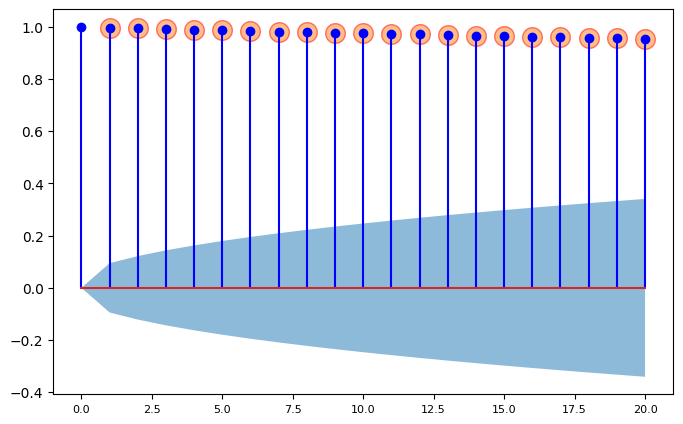

In [26]:
price_ac.acf_plot()

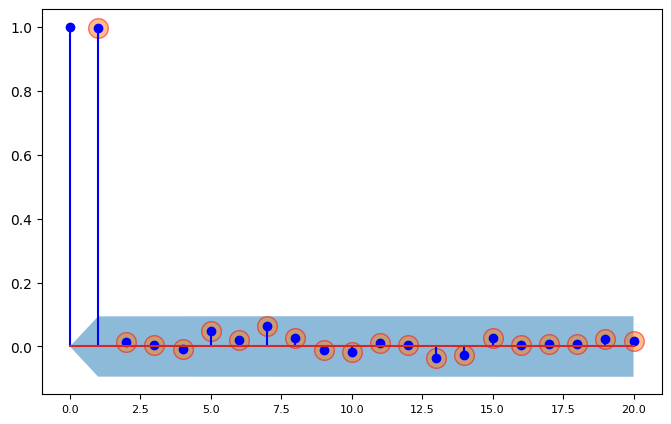

In [27]:
price_ac.pacf_plot()

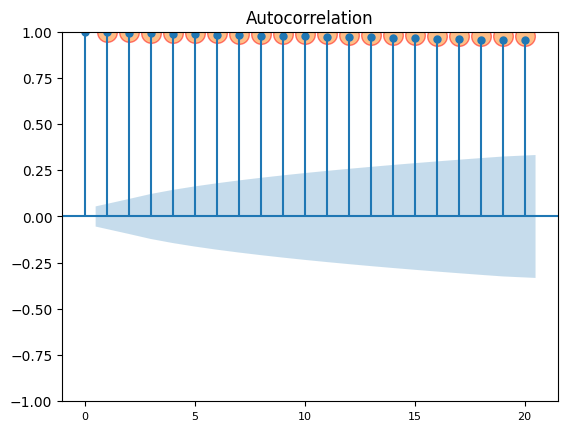

In [28]:
acf_plot(price, 20)

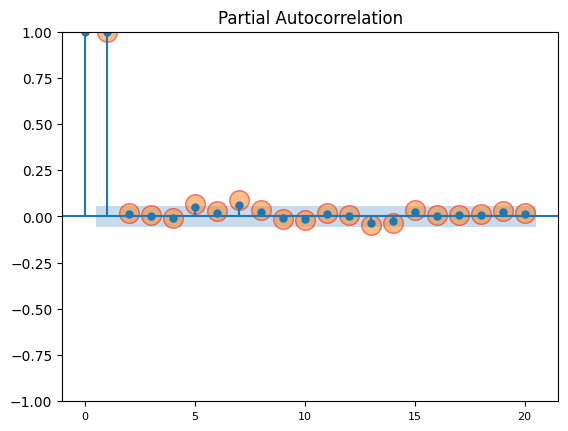

In [29]:
pacf_plot(price, 20)

In [30]:
diff_ac = autocorrelation(diff,20)

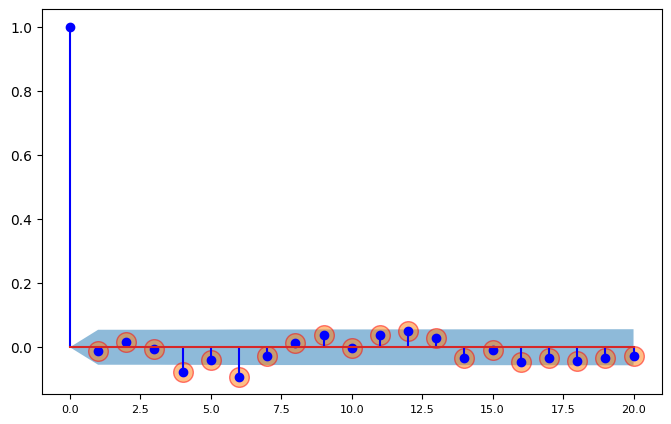

In [31]:
diff_ac.acf_plot()

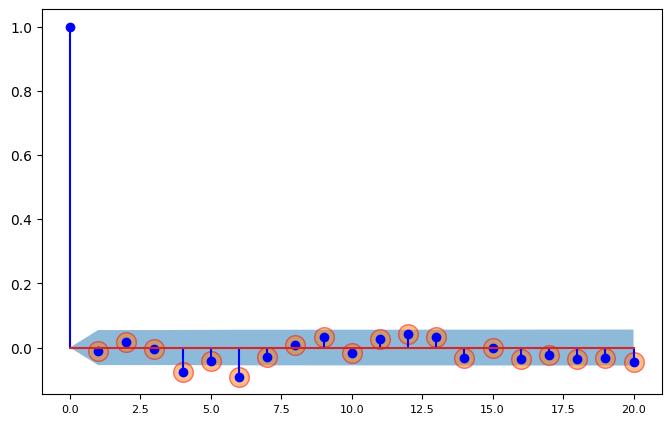

In [32]:
diff_ac.pacf_plot()

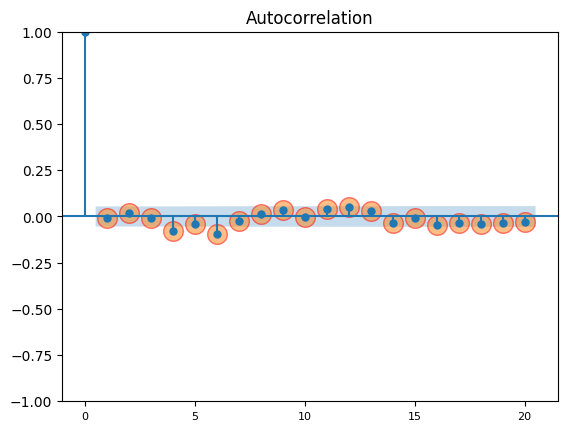

In [33]:
acf_plot(diff, 20)

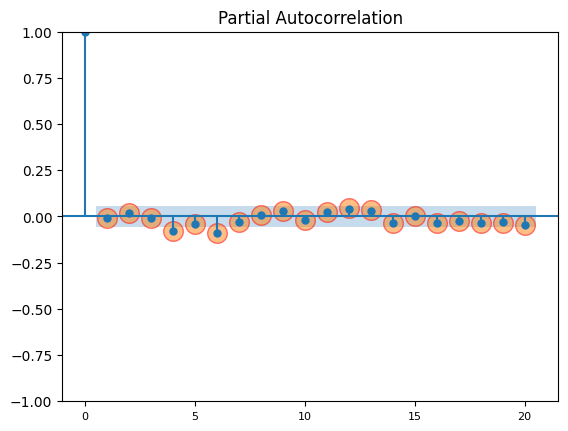

In [34]:
pacf_plot(diff, 20)

# ARIMA

## Train-Test split

In [35]:
forecasting_horizon = int(gold.shape[0]*0.2)
train = price[:-forecasting_horizon]
test = price[-forecasting_horizon:]

## Fitting

In [36]:
p = range(0,6)
d = range(0,3)
q = range(0,6)

orders = list(itertools.product(p,d,q))

In [ ]:
#Gold select order
dict_model = {}

for order in orders:
    model = ARIMA(train, order = order)
    model_fit = model.fit()
    dict_model[order] = [model_fit.llf, model_fit.aic, model_fit.bic]

information = pd.DataFrame.from_dict(dict_model, orient='index', columns=['llf', 'Aic', 'Bic'])
print('By BIC')
print(information.sort_values(by=['Bic'], ascending =True))

In [ ]:
model_aic = pm.auto_arima(train, information_criteria = 'aic')
model_bic = pm.auto_arima(train, information_criteria = 'bic')

print(model_aic.summary())
print(model_bic.summary())

## Forecasting

In [ ]:
#ARIMA(0,1,0)
arima_errors = []
arima_preds = []
order = (0,1,0)


for i in range(forecasting_horizon) :
    arima_model = ARIMA(price[:-forecasting_horizon+i], order = order)
    arima_model_fit = arima_model.fit()
    arima_pred = arima_model_fit.forecast(steps=1).item()
    arima_error = arima_pred - price.iloc[price.shape[0]-forecasting_horizon+i].item()
    arima_abs_error = abs(arima_error)
    arima_preds.append(arima_pred)
    arima_errors.append(arima_abs_error)


arima_abs_errors = np.array(arima_errors)
arima = arima_abs_errors.mean()
print(arima)

11.584883720930227


In [ ]:
#Auto-ARIMA
arima_errors1 = []
arima_preds1 = []


for i in range(forecasting_horizon) :
    arima_model1 = pm.auto_arima(price[:-forecasting_horizon+i], max_p = 2, max_q=2, d =1, information_criteria = 'bic')
    arima_pred1 = arima_model1.predict(1).item()
    arima_error1 = arima_pred1 - price.iloc[price.shape[0]-forecasting_horizon+i].item()
    arima_abs_error1 = abs(arima_error1)
    arima_preds1.append(arima_pred1)
    arima_errors1.append(arima_abs_error1)


arima_abs_errors1 = np.array(arima_errors1)
arima1 = arima_abs_errors1.mean()
print(arima1)

11.551172589344901


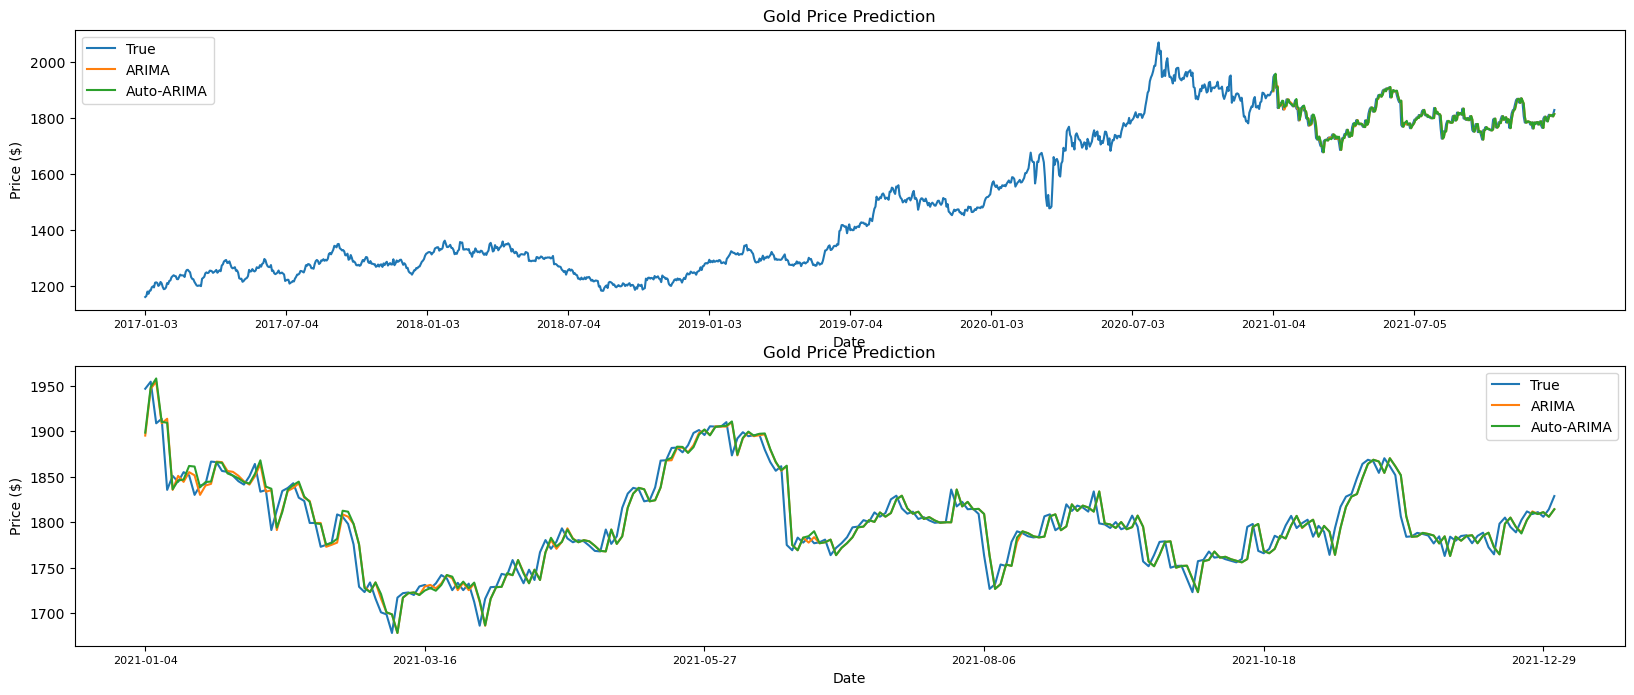

In [ ]:
preds = pd.DataFrame(arima_preds, index = gold['Date'][-forecasting_horizon:])
preds1 = pd.DataFrame(arima_preds1, index = gold['Date'][-forecasting_horizon:])

fig, ax = plt.subplots(2,1,figsize = (20,8))
x1 = gold['Date']
x2 = gold['Date'][-forecasting_horizon:]

ax[0].plot(x1, price, label = 'True')
ax[0].plot(x2, preds, label = 'ARIMA')
ax[0].plot(x2, preds1, label = 'Auto-ARIMA')
ax[0].set_title('Gold Price Prediction')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price ($)')
ax[0].legend()

ax[1].plot(x2, price[-forecasting_horizon:], label = 'True')
ax[1].plot(x2, preds, label = 'ARIMA')
ax[1].plot(x2, preds1, label = 'Auto-ARIMA')
ax[1].set_title('Gold Price Prediction')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Price ($)')
ax[1].legend()

total_len = gold.shape[0]
ax[0].set_xticks(np.arange(0,total_len, 129))
ax[1].set_xticks(np.arange(0,forecasting_horizon, int(forecasting_horizon*0.2)))


plt.show()

In [ ]:
order = (0,1,0)
arima_model_dms = ARIMA(price[:-forecasting_horizon], order = order)
arima_model_dms_fit = arima_model_dms.fit()
arima_dms_pred = arima_model_dms_fit.forecast(steps=forecasting_horizon)
arima_dms_error = arima_dms_pred - gold['Price'][price.shape[0]-forecasting_horizon:]
arima_dms_abs_error = abs(arima_dms_error)
arima_dms_abs_error = np.array(arima_dms_abs_error)
print(arima_dms_abs_error.mean())

arima_model_dms1 = pm.auto_arima(price[:-forecasting_horizon], max_p = 3, max_q=3, d =1, information_criteria = 'bic')
arima_dms_pred1 = arima_model_dms1.predict(forecasting_horizon)
arima_dms_error1 = arima_dms_pred1 - gold['Price'][price.shape[0]-forecasting_horizon:]
arima_dms_abs_error1 = abs(arima_dms_error1)
arima_dms_abs_error1 = np.array(arima_dms_abs_error1)
arima_dms_abs_error1.mean()

97.13333333333325


191.32826600963224

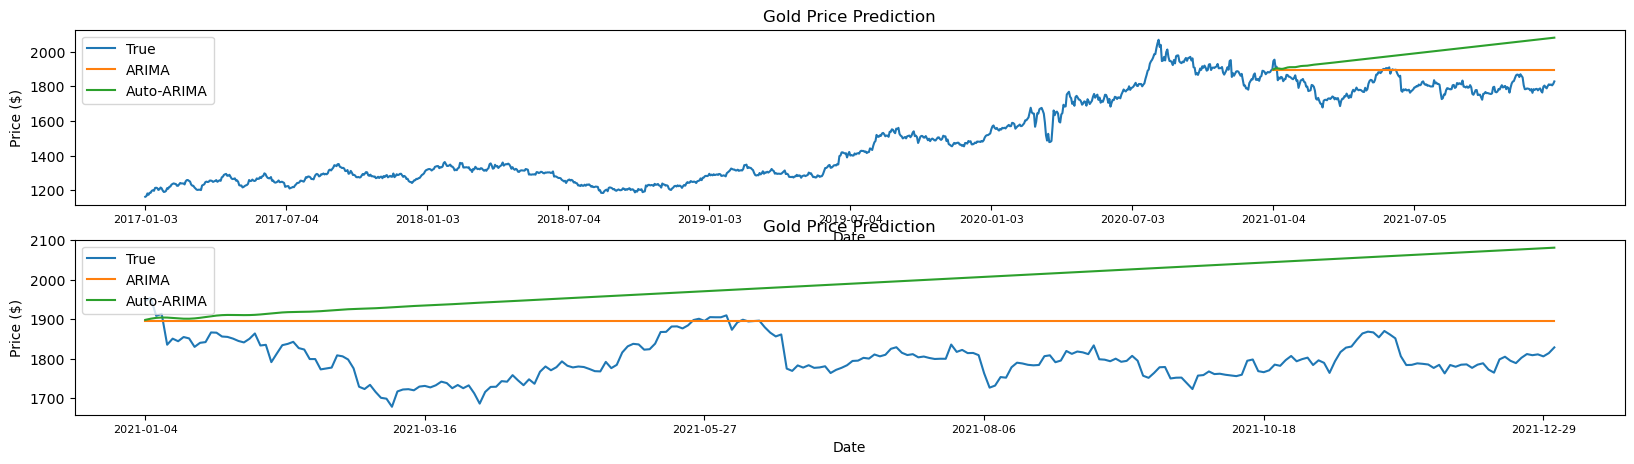

In [ ]:
preds_dms= pd.DataFrame(arima_dms_pred.to_numpy(), index = gold['Date'][-forecasting_horizon:])
preds_dms1= pd.DataFrame(arima_dms_pred1.to_numpy(), index = gold['Date'][-forecasting_horizon:])


fig, ax = plt.subplots(2,1,figsize = (20,5))
x1 = gold['Date']
x2 = gold['Date'][-forecasting_horizon:]

ax[0].plot(x1, price, label = 'True')
ax[0].plot(x2, preds_dms, label = 'ARIMA')
ax[0].plot(x2, preds_dms1, label = 'Auto-ARIMA')
ax[0].set_title('Gold Price Prediction')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price ($)')
ax[0].legend()

ax[1].plot(x2, price[-forecasting_horizon:], label = 'True')
ax[1].plot(x2, preds_dms, label = 'ARIMA')
ax[1].plot(x2, preds_dms1, label = 'Auto-ARIMA')
ax[1].set_title('Gold Price Prediction')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Price ($)')
ax[1].legend()

total_len = gold.shape[0]
ax[0].set_xticks(np.arange(0,total_len, 129))
ax[1].set_xticks(np.arange(0,forecasting_horizon, int(forecasting_horizon*0.2)))


plt.show()